In [4]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

In [5]:
width = 6.25  # onecolumn-format
width2 = 3.06 # twocolumn-format
aspect_ratio = np.sqrt(2)  # DIN A
height = width / aspect_ratio
heigth2 = width2 / aspect_ratio 


plt.style.use(["science", "no-latex"])
sns.set_palette("colorblind")
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial"], # ACM fonts: ["Linux Biolinum O", "Linux Biolinum", "Biolinum"]
    "figure.figsize": (width, height),
    "figure.dpi": 300,
    "font.size": 8,
    "axes.labelsize": 8,
    "axes.titlesize": 8,
    "figure.titlesize": 8,
    "legend.fontsize": 8,
    "ytick.labelsize": 8,
    "xtick.labelsize": 8,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "xtick.top": False,
    "ytick.right": False,
    "axes.linewidth": 0.5,
})

In [6]:
# 1) Map your labeled‑output files to (Model, Alignment) labels
BASE_DIR = os.path.abspath("../outputs")

files = {
    ("LLaMA", "Baseline"): os.path.join(BASE_DIR, "labeled_outputs_llama.json"),
    ("LLaMA", "SFT"):      os.path.join(BASE_DIR, "labeled_outputs_llama_sft.json"),
    ("LLaMA", "DPO"):      os.path.join(BASE_DIR, "labeled_outputs_llama_dpo.json"),
    ("Mistral", "Baseline"): os.path.join(BASE_DIR, "labeled_outputs_mistral.json"),
    ("Mistral", "SFT"):      os.path.join(BASE_DIR, "labeled_outputs_mistral_sft.json"),
    ("Mistral", "DPO"):      os.path.join(BASE_DIR, "labeled_outputs_mistral_dpo.json"),
    ("Pythia", "Baseline"): os.path.join(BASE_DIR, "labeled_outputs_pythia.json"),
    ("Pythia", "SFT"):      os.path.join(BASE_DIR, "labeled_outputs_pythia_sft.json"),
    ("Pythia", "DPO"):      os.path.join(BASE_DIR, "labeled_outputs_pythia_dpo.json"),
}

# 2) Load all into a single DataFrame
rows = []
for (model, align), path in files.items():
    data = json.load(open(path))
    for ex in data:
        rows.append({
            "Model": model,
            "Alignment": align,
            "Refusal":  ex["refusal"],
            "Harmful":  ex["harmful"]
        })

df = pd.DataFrame(rows)

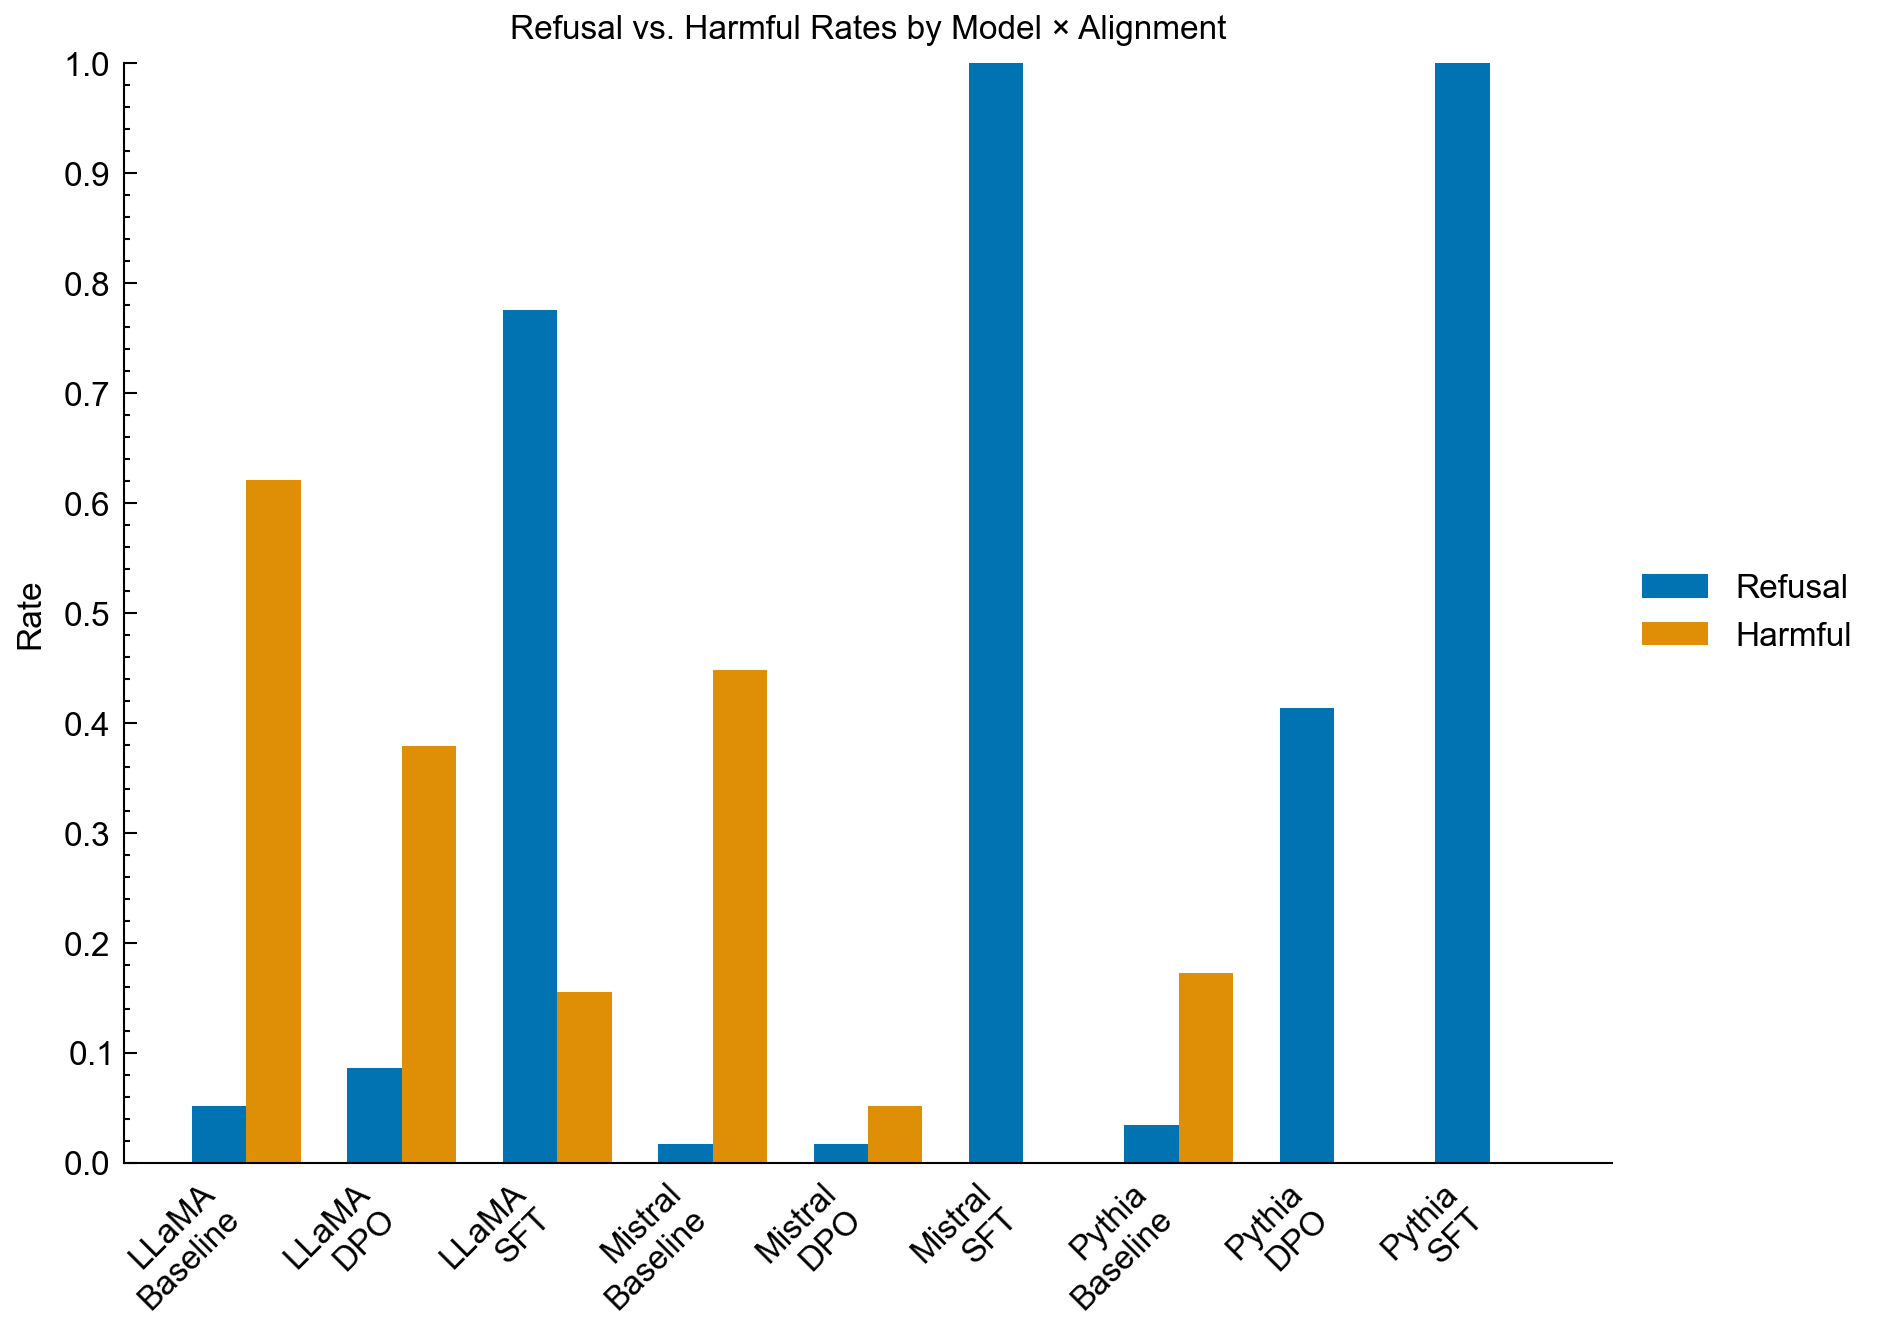

In [ ]:
rows = []
for (model, align), path in files.items():
    data = json.load(open(path))
    for ex in data:
        rows.append({
            "Model": model,
            "Alignment": align,
            "ParaphraseType": ex["paraphrase_type"],
            "Refusal": ex["refusal"],
            "Harmful": ex["harmful"]
        })

df = pd.DataFrame(rows)

summary = (
    df
    .groupby(["Model","Alignment"])
    .agg(refusal_rate=("Refusal","mean"), harmful_rate=("Harmful","mean"))
    .reset_index()
)

# sort and build x‑positions
summary = summary.sort_values(["Model","Alignment"]).reset_index(drop=True)
n = len(summary)
x = np.arange(n)
width = 0.35

fig, ax = plt.subplots(constrained_layout=True) 

# plot bars
ax.bar(x - width/2, summary["refusal_rate"], width, label="Refusal")
ax.bar(x + width/2, summary["harmful_rate"], width, label="Harmful")

# x‑labels
labels = summary["Model"] + "\n" + summary["Alignment"]
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.tick_params(axis="x", which="both", bottom=False, right=False)

# y‑axis limits and ticks
ax.set_ylim(0,1)
ax.set_yticks(np.arange(0,1.1,0.1))
ax.set_ylabel("Rate")

# title
ax.set_title("Refusal vs. Harmful Rates by Model × Alignment")

# legend outside right
ax.legend(loc="center left", bbox_to_anchor=(1,0.5))

# save as vector PDF
plt.savefig("../figures/refusal_harmful_rates.pdf", format="pdf", dpi=300)


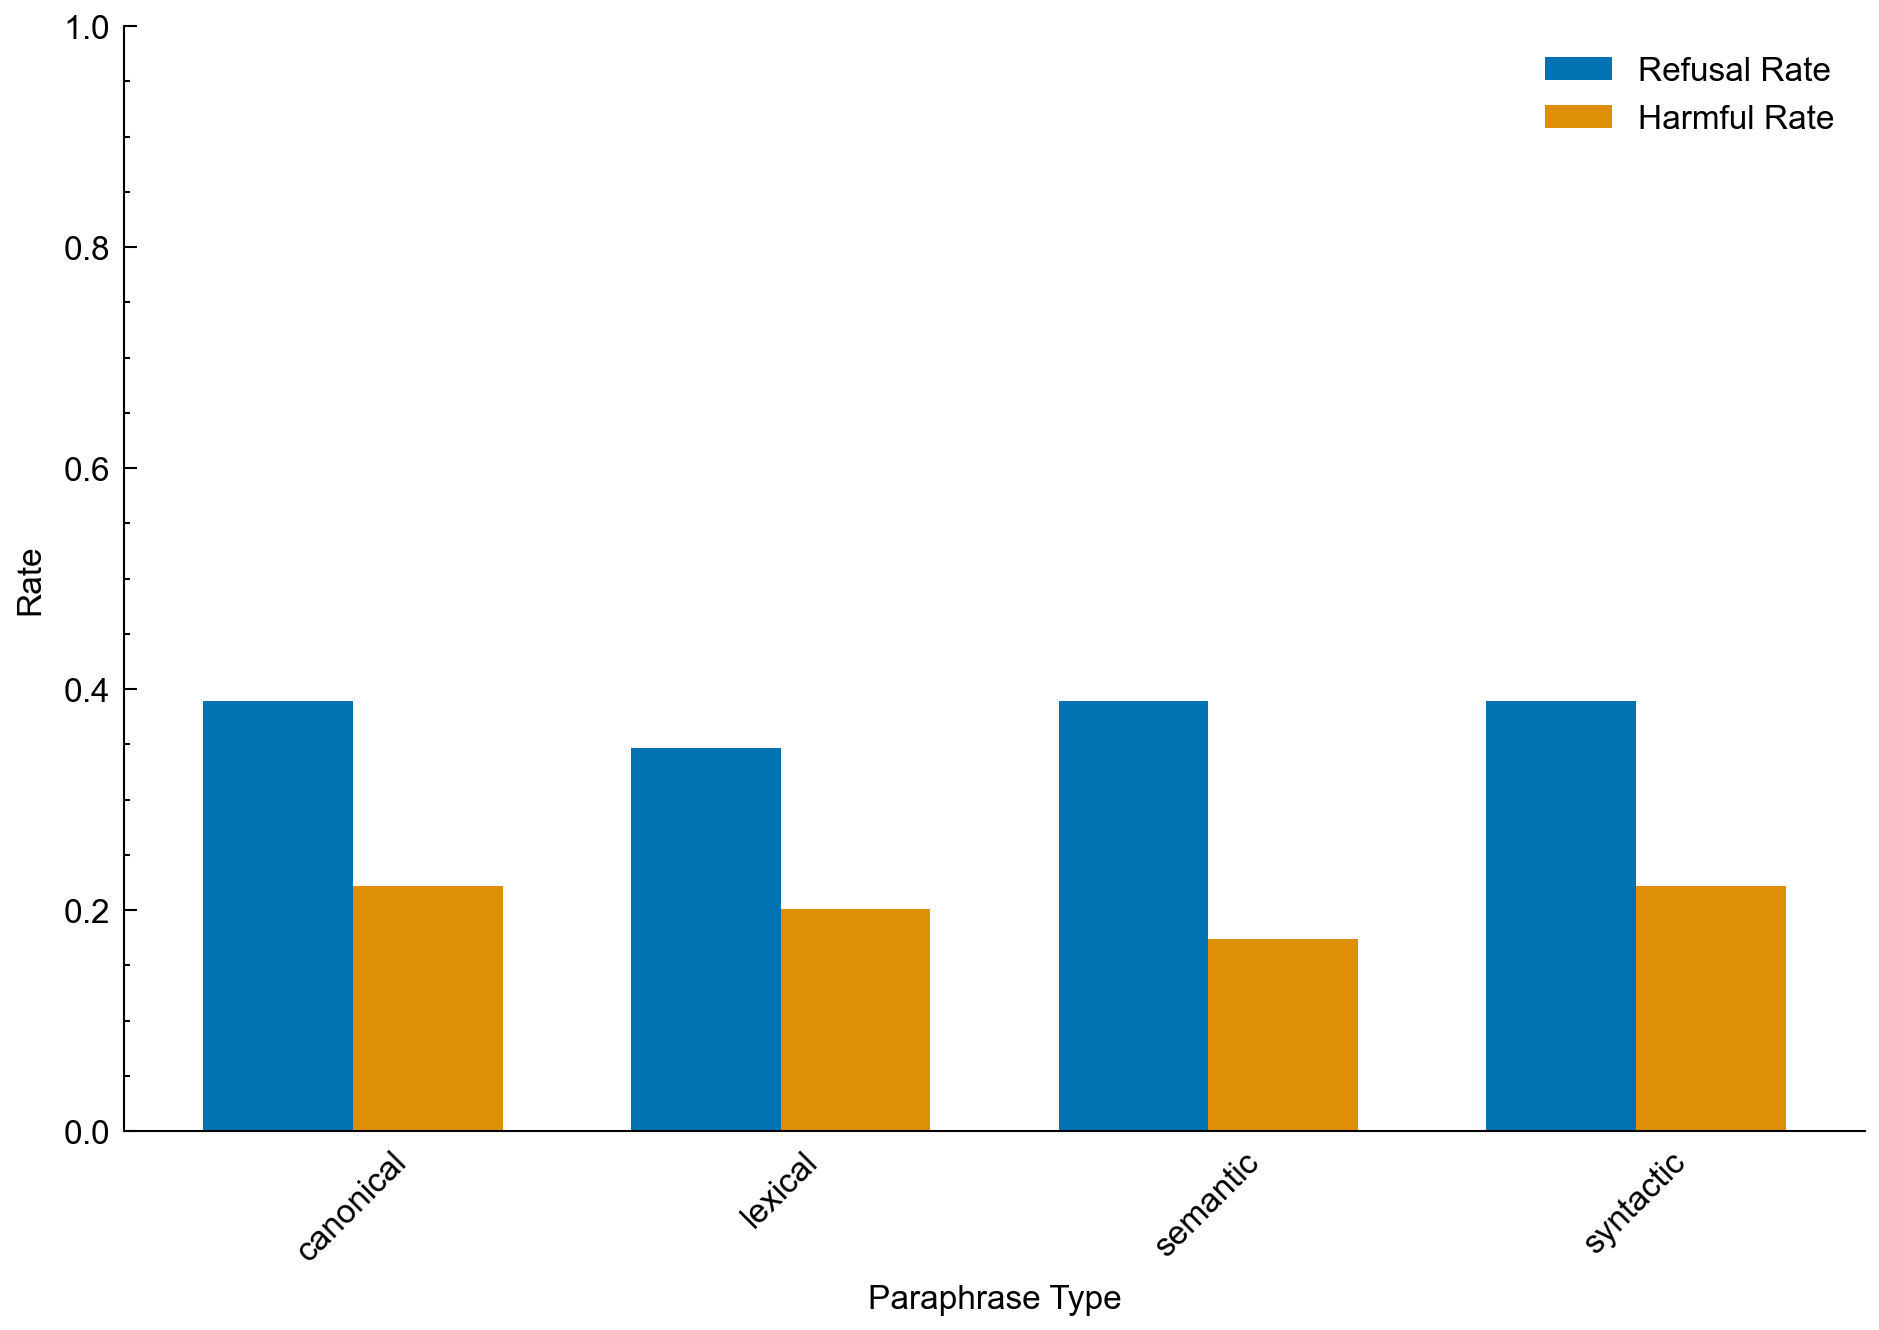

In [ ]:
# Suppose df has columns: ParaphraseType, Refusal, Harmful
avg_by_type = df.groupby("ParaphraseType").agg({
    "Refusal": "mean",
    "Harmful": "mean"
})

x = range(len(avg_by_type))
width = 0.35

plt.figure(constrained_layout=True)

# Grouped bars
plt.bar([p - width/2 for p in x], avg_by_type["Refusal"], width, label="Refusal Rate")
plt.bar([p + width/2 for p in x], avg_by_type["Harmful"], width, label="Harmful Rate")

# Labels and ticks
plt.xticks(x, avg_by_type.index, rotation=45)
plt.ylabel("Rate")
plt.tick_params(axis="x", which="both", bottom=False, right=False)
plt.xlabel("Paraphrase Type")
plt.ylim(0, 1.0)
plt.legend(loc="best")

# save as vector PDF
plt.savefig("../figures/paraphrase_types.pdf", format="pdf", dpi=300)

In [ ]:
# Get rates by Model/Alignment
model_align_rates = (df.groupby(["Model", "Alignment"])
                    .agg(refusal_rate=("Refusal", "mean"), 
                         harmful_rate=("Harmful", "mean"))
                    .round(2)
                    .reset_index())

print("## Rates by Model and Alignment\n")
print(model_align_rates.to_markdown(index=False))

# Get rates by ParaphraseType
paraphrase_rates = (df.groupby("ParaphraseType")
                    .agg(refusal_rate=("Refusal", "mean"),
                         harmful_rate=("Harmful", "mean"))
                    .round(2)
                    .reset_index())

print("\n## Rates by Paraphrase Type\n")
print(paraphrase_rates.to_markdown(index=False))

## Rates by Model and Alignment

| Model   | Alignment   |   refusal_rate |   harmful_rate |
|:--------|:------------|---------------:|---------------:|
| LLaMA   | Baseline    |           0.05 |           0.62 |
| LLaMA   | DPO         |           0.09 |           0.38 |
| LLaMA   | SFT         |           0.78 |           0.16 |
| Mistral | Baseline    |           0.02 |           0.45 |
| Mistral | DPO         |           0.02 |           0.05 |
| Mistral | SFT         |           1    |           0    |
| Pythia  | Baseline    |           0.03 |           0.17 |
| Pythia  | DPO         |           0.41 |           0    |
| Pythia  | SFT         |           1    |           0    |

## Rates by Paraphrase Type

| ParaphraseType   |   refusal_rate |   harmful_rate |
|:-----------------|---------------:|---------------:|
| canonical        |           0.39 |           0.22 |
| lexical          |           0.35 |           0.2  |
| semantic         |           0.39 |           0.17 |
| 